In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
#setup API key
import os
OPENAI_API_KEY=os.getenv("OPENAI_API_KEY")

In [3]:
#Setting up the environmet key
os.environ["OPENAI_API_KEY"]=OPENAI_API_KEY

In [119]:
#Lets import the required libraries
import pandas as pd
from langgraph.graph import StateGraph,MessagesState, START, END
from langgraph.graph.message import add_messages
# from typing import Annotated, Literal, List   #
from typing_extensions import TypedDict, Annotated, Literal, List
from langchain_core.tools import tool    #for creating Tool
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver   #To sustain the memory
from langgraph.prebuilt import ToolNode,tools_condition     #To create the Nodes for Tool
from langgraph.checkpoint.memory import MemorySaver

In [5]:
#Load the model
from langchain_openai import ChatOpenAI
openai_model=ChatOpenAI(model="gpt-4o")

In [6]:
openai_model.invoke('Hi, My Name is Yaseen')

AIMessage(content='Hello, Yaseen! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 15, 'total_tokens': 28, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_9bddfca6e2', 'id': 'chatcmpl-BcH8Ncs5P86uKBClItJlEDPVvc5NO', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--09cee675-aaf0-4f52-a515-c96b6952cdd5-0', usage_metadata={'input_tokens': 15, 'output_tokens': 13, 'total_tokens': 28, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [9]:
#We have our model ready, now lets create a Tool

In [163]:
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]
    meetings: list[dict]  # <- This will store the output of load_meeting_data
    analysis: list[str]


In [164]:
#Load meeting data
@tool
def load_meeting_data() -> List[TypedDict]:
    """Tool to load meeting data from a CSV file."""
    df = pd.read_csv("yaseen_khan_missed_meetings_2.csv")
    df = df[0:5]
    meetings = df.to_dict(orient="records")
    return {"meetings": meetings}

In [165]:
@tool
def analyze_meetings_batch(state: AgentState) -> list[str]:
    """Analyzes multiple meetings and returns summaries for each."""
    meetings = state.get("meetings", [])
    results = []

    for i, meeting in enumerate(meetings, 1):
        mom = meeting.get("MOM Content", "")
        transcript = meeting.get("Transcript Content", "")

        if mom:
            content = f"MoM:\n{mom}"
        elif transcript:
            content = f"Transcript:\n{transcript}"
        else:
            results.append(f"Meeting {i}: No MoM or Transcript available.")
            continue

        prompt = f"""
        You're an AI assistant of User, responsible for analyzing meeting content which he missed during his leave.
        Your task is to read the content of the meeting, analyze it, and recommend actions such as tasks to complete, follow-up meetings to schedule, or status updates to provide.

        Meeting {i} content:
        {content}
        """
        response = openai_model.invoke(prompt)
        results.append(f"Meeting {i} Summary:\n{response.content.strip()}")

    return {"analysis": results}


In [166]:
#Defing the tool name as below
tools=[load_meeting_data,analyze_meetings_batch]

In [167]:
#We are binding the tool
llm_with_tool=openai_model.bind_tools(tools)

In [168]:
response=llm_with_tool.invoke("My Name is Yaseen Khan")
response

AIMessage(content='Hello Yaseen Khan! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 87, 'total_tokens': 101, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-BcJ1pR4PhYI9q4RQoeOg2dfiFGZpK', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--0c2a4b01-cf6b-406c-936d-e49cbb1bc567-0', usage_metadata={'input_tokens': 87, 'output_tokens': 14, 'total_tokens': 101, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [126]:
response=llm_with_tool.invoke("can you load the meeting data?")
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_fwEKjd6Muybl75aAq9oF4YYQ', 'function': {'arguments': '{}', 'name': 'load_meeting_data'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 83, 'total_tokens': 95, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_76544d79cb', 'id': 'chatcmpl-BcIfAYXsbOkhToUzpnvsh9NTQ4Wu1', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--10129a96-bf7a-4bfc-9973-b955892ecc60-0', tool_calls=[{'name': 'load_meeting_data', 'args': {}, 'id': 'call_fwEKjd6Muybl75aAq9oF4YYQ', 'type': 'tool_call'}], usage_metadata={'input_tokens': 83, 'output_tokens': 12, 'total_tokens': 95, 'input_token_details': {'audio': 0, 'cache_read': 0},

In [127]:
llm_with_tool.invoke("can you load the meetings?").tool_calls

[{'name': 'load_meeting_data',
  'args': {},
  'id': 'call_tUnMVOFYezPamKbLXLO6pU6y',
  'type': 'tool_call'}]

In [129]:
llm_with_tool.invoke("can you load and analyse the meetings?").tool_calls

[{'name': 'load_meeting_data',
  'args': {},
  'id': 'call_MIrydIPIJ6n4hMX5C5cPQaNm',
  'type': 'tool_call'},
 {'name': 'analyze_meetings_batch',
  'args': {'state': {'messages': []}},
  'id': 'call_JKg8FBDQZjVIEwhuBGjLnuP6',
  'type': 'tool_call'}]

In [169]:
from langchain_core.messages import HumanMessage, SystemMessage
# System message
sys_msg = SystemMessage(content="You are a helpful assistant interact with user gently and upon asked you will load the meeting data and analyze it to provide recommendations.")


In [174]:
#Defining the supervisor node as our llm
def call_model(state:AgentState) -> dict:
    question=state["messages"]  # Get the last message from the state
    response=llm_with_tool.invoke([sys_msg]+question)  #instead of invoking the normal llm , we are using the binding llm which is binded to a tool
    return {"messages":[response]}

In [175]:
#lets ask a simpe query
input={'messages': ['load the outlook data']}  #quer
response=call_model(input)  #call the function with query and store the resul in response variable
message=response["messages"]  #Take only messages from response
last_message=message[-1]  #Take the last message from all the messages
last_message

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_EetkfAyR4QqmLCdG7PSVC5NF', 'function': {'arguments': '{}', 'name': 'load_meeting_data'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 109, 'total_tokens': 121, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f5bdcc3276', 'id': 'chatcmpl-BcJ3jLiP744yrdOjaTLYL7sv6dwdR', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--26a71194-f3ac-4ed6-810c-61bdaee1ae4f-0', tool_calls=[{'name': 'load_meeting_data', 'args': {}, 'id': 'call_EetkfAyR4QqmLCdG7PSVC5NF', 'type': 'tool_call'}], usage_metadata={'input_tokens': 109, 'output_tokens': 12, 'total_tokens': 121, 'input_token_details': {'audio': 0, 'cache_read':

In [147]:
tools

[StructuredTool(name='load_meeting_data', description='Tool to load meeting data from a CSV file.', args_schema=<class 'langchain_core.utils.pydantic.load_meeting_data'>, func=<function load_meeting_data at 0x000001D31A693100>),
 StructuredTool(name='analyze_meetings_batch', description='Analyzes multiple meetings and returns summaries for each.', args_schema=<class 'langchain_core.utils.pydantic.analyze_meetings_batch'>, func=<function analyze_meetings_batch at 0x000001D31A6931A0>)]

In [176]:
#Note: we have to create this tool as node for orchaestration pupose
# for this tool to consume it as node inside our workflow, we have use this method below
tool_node=ToolNode(tools)

#now this "tool_node" variable is the node of our tool which can be used in orchaestrtion

In [177]:
#Lets define a router and orchaestrate the workflow
def router_function(state: AgentState) -> Literal["tools", END]:
    message=state["messages"]
    last_message=message[-1]
    if last_message.tool_calls:
        return "tools"
    return END

In [178]:
#Lets create the workflow with this router
workflow=StateGraph(AgentState)

In [179]:
#create the nodes
workflow.add_node("assistant",call_model)
workflow.add_node("load&analyse_meetings", tool_node)#Consuming tool as node

In [180]:
#Define the endges (conditional edges )
workflow.add_edge(START, "assistant")

workflow.add_conditional_edges("assistant",
                               router_function,
                               {"tools": "load&analyse_meetings", END:END})
workflow.add_edge("load&analyse_meetings", "assistant")
workflow.add_edge("assistant", END)




In [181]:
#Lets compile
memory_saver = MemorySaver()
from uuid import uuid4
session_id = str(uuid4())

app = workflow.compile(checkpointer=memory_saver)

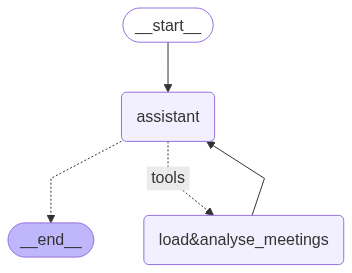

In [182]:
#Lets visualize the graph
from IPython.display import Image,display
display(Image(app.get_graph().draw_mermaid_png()))

In [183]:
#Now lets invoke this app

#invoking with a simple message
# message=[HumanMessage(content="My Name is Yaseen Khan")]
# response=app.invoke({"messages": message}, config={"configurable": {"thread_id": session_id}})
# response

#Here we are getting the AI message from LLM (assistant) directly as this is simple query

In [184]:
message=[HumanMessage(content="can you load the meeting data and analyse each meeting and recommend the action itmes in each meeting?")]
response=app.invoke({"messages": message},config={"configurable": {"thread_id": session_id}})
response


{'messages': [HumanMessage(content='can you load the meeting data and analyse each meeting and recommend the action itmes in each meeting?', additional_kwargs={}, response_metadata={}, id='f3f876cf-a606-45b8-a44d-64d77dee6cf3'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_TPMdSTKuN8JKag8J9E3cqTTH', 'function': {'arguments': '{}', 'name': 'load_meeting_data'}, 'type': 'function'}, {'id': 'call_dQPmYzkYcVldfQsagcpAr4jU', 'function': {'arguments': '{"state": {"messages": [], "analysis": []}}', 'name': 'analyze_meetings_batch'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 52, 'prompt_tokens': 125, 'total_tokens': 177, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f5bdcc3276', 'id': 'chatcmpl-BcJ

In [105]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

My Name is Yaseen Khan
================================== Ai Message ==================================

Hello Yaseen Khan! How can I assist you today?
================================ Human Message =================================

can you load the meeting data and analyse each meeting and recommend the action itmes in each meeting?
================================== Ai Message ==================================
Tool Calls:
  load_meeting_data (call_bj1WCGAnOqGhv8HYnTDrH1hG)
 Call ID: call_bj1WCGAnOqGhv8HYnTDrH1hG
  Args:
  analyze_meetings_batch (call_8rkizzOAqc0BhUuTUn4qbDsA)
 Call ID: call_8rkizzOAqc0BhUuTUn4qbDsA
  Args:
================================= Tool Message =================================
Name: load_meeting_data

[{"Meeting_ID": "MTG0001", "Title": "Whiteboard Web-Enabled Roi", "Date_Time": "4/27/2025 12:00", "Duration": 15, "Attendees": "Yaseen Khan, Lauren Raymond, James Mccoy, Mrs. Am